In [2]:
import omnitool
from omnitool.literature_values import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
#Read in Jie Yu
sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Yu+18_table1.txt'
cols = ['KICID','numax','err','dnu','err.1']
yu18_1 = pd.read_csv(sfile, usecols=cols, sep='|')

sfile = '/home/oliver/PhD/Catalogues/RC_catalogues/Yu+18_table2.txt'
cols = ['KICID','Teff','logg','err.1_y','err','Fe/H','err.2','EvoPhase']
yu18_2 = pd.read_csv(sfile, usecols=cols, sep='|')
yu18 = pd.merge(yu18_1, yu18_2, on='KICID',how='outer')
yu18.rename(columns={'EvoPhase':'stage',
                    'err_x':'numax_err',
                    'err.1':'dnu_err',
                    'err_y':'Teff_err',
                     'Fe/H':'[Fe/H]',
                    'err.2':'[Fe/H]_err',
                    'err.1_y':'logg_err',
                    'err.3_y':'M_err',
                    'err.4_y':'R_err'},inplace=True) #For consistency
yu18.head(2)

,KICID,numax,numax_err,dnu,dnu_err,Teff,Teff_err,[Fe/H],[Fe/H]_err,stage
0,757137,29.99,0.60,3.399,0.011,4751,139,-0.08,0.3,1
1,892010,17.85,0.89,2.427,0.078,4834,151,0.21,0.3,0


In [32]:
#Now lets read in the KICID and relevant information from APOKASC
sfile = '/home/oliver/PhD/Catalogues/APOKASC/APOKASC_cat_v3.6.5.txt'
cols= ['KEPLER_ID','GAIA_PARALLAX','GAIA_PARALLAX_ERR',\
      'J_MAG_2M', 'J_MAG_ERR', 'H_MAG_2M', 'H_MAG_ERR',\
       'K_MAG_2M', 'K_MAG_ERR','RA','DEC']

apokasc = pd.read_csv(sfile, usecols=cols, skiprows=644,sep='\s+')
apokasc.rename(columns={'KEPLER_ID':'KICID'},inplace=True)

apokasc.head(2)

,KICID,RA,DEC,GAIA_PARALLAX,GAIA_PARALLAX_ERR,J_MAG_2M,J_MAG_ERR,H_MAG_2M,H_MAG_ERR,K_MAG_2M,K_MAG_ERR
0,10000207,286.374415,46.910336,-9999.0,-9999.0,10.811,0.021,10.261,0.017,10.172,0.012
1,10000547,286.591376,46.950447,-9999.0,-9999.0,10.712,0.021,10.247,0.019,10.161,0.014


In [34]:
#Now lets combine and make cuts
print('X-matching Yu18 and APOKASC...')
print('Before: '+str(len(yu18)))
df = pd.merge(yu18, apokasc, on='KICID',how='outer').reindex()
df = df[~df.numax.isnull()].reindex()
print('After: '+str(len(df)))
df.head(2)

X-matching Yu18 and APOKASC...
Before: 16094
After: 16094


,KICID,numax,numax_err,dnu,dnu_err,Teff,Teff_err,[Fe/H],[Fe/H]_err,stage,RA,DEC,GAIA_PARALLAX,GAIA_PARALLAX_ERR,J_MAG_2M,J_MAG_ERR,H_MAG_2M,H_MAG_ERR,K_MAG_2M,K_MAG_ERR
0,757137,29.99,0.60,3.399,0.011,4751.0,139.0,-0.08,0.3,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,892010,17.85,0.89,2.427,0.078,4834.0,151.0,0.21,0.3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
#Now lets combine and make cuts
print('X-matching Yu18xAPOKASC and Gaia Data')
print('Before: '+str(len(df)))
df = df[~df.GAIA_PARALLAX.isnull()].reindex()
df = df[df.GAIA_PARALLAX > -9000.].reindex()
print('After: '+str(len(df)))
df.head(2)

X-matching Yu18xAPOKASC and Gaia Data
Before: 16094
After: 2212


,KICID,numax,numax_err,dnu,dnu_err,Teff,Teff_err,[Fe/H],[Fe/H]_err,stage,RA,DEC,GAIA_PARALLAX,GAIA_PARALLAX_ERR,J_MAG_2M,J_MAG_ERR,H_MAG_2M,H_MAG_ERR,K_MAG_2M,K_MAG_ERR
16,1160789,24.72,0.62,3.509,0.048,4724.0,80.0,-0.27,0.15,2.0,290.886667,36.872429,1.34998,0.321796,8.133,0.021,7.593,0.021,7.497,0.017
18,1161618,34.32,0.50,4.108,0.028,4747.0,80.0,0.08,0.15,2.0,291.108918,36.813293,1.22824,0.357921,8.542,0.018,7.974,0.026,7.887,0.018


In [36]:
#Kill negative parallaxes
print('Removing negative parallaxes & those with error < 40%')
print('Before: '+str(len(df)))
sel = (df.GAIA_PARALLAX_ERR < 0.4*df.GAIA_PARALLAX) & (df.GAIA_PARALLAX > 0.)
df = df[sel].reindex()
print('After: '+str(len(df)))
df.head(2)

Removing negative parallaxes & those with error < 40%
Before: 2212
After: 1256


,KICID,numax,numax_err,dnu,dnu_err,Teff,Teff_err,[Fe/H],[Fe/H]_err,stage,RA,DEC,GAIA_PARALLAX,GAIA_PARALLAX_ERR,J_MAG_2M,J_MAG_ERR,H_MAG_2M,H_MAG_ERR,K_MAG_2M,K_MAG_ERR
16,1160789,24.72,0.62,3.509,0.048,4724.0,80.0,-0.27,0.15,2.0,290.886667,36.872429,1.34998,0.321796,8.133,0.021,7.593,0.021,7.497,0.017
18,1161618,34.32,0.50,4.108,0.028,4747.0,80.0,0.08,0.15,2.0,291.108918,36.813293,1.22824,0.357921,8.542,0.018,7.974,0.026,7.887,0.018


In [37]:
#Replacing negative magnitude error spaces with 0. errors
sel = df.K_MAG_ERR <0.
df['K_MAG_ERR'][sel] = 0.
sel = df.H_MAG_ERR <0.
df['H_MAG_ERR'][sel] = 0.
sel = df.J_MAG_ERR <0.
df['J_MAG_ERR'][sel] = 0.

#Finally, killing any ridiculous magnitude error outliers as unrealistic
sel = df.K_MAG_ERR >9.
df['K_MAG_ERR'][sel] = 0.
sel = df.H_MAG_ERR >9.
df['H_MAG_ERR'][sel] = 0.
sel = df.J_MAG_ERR >9.
df['J_MAG_ERR'][sel] = 0.


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: 

In [38]:
'''Now lets get run the scaling relations and get the abs magnitudes'''

'Now lets get run the scaling relations and get the abs magnitudes'

In [39]:
#First, lets use asteroseismology scaling relations
sc = omnitool.scalings(df, df.numax, df.dnu, df. Teff,\
                      _numax_err = df.numax_err, _dnu_err = df.dnu_err,\
                      _Teff_err = df.Teff_err)
df['R'] = sc.get_radius()/Rsol
df['R_err'] = sc.get_radius_err()/Rsol
df['M'] = sc.get_mass()/Msol
df['M_err'] = sc.get_mass_err()/Msol
df['logg'] = sc.get_logg()
df['logg_err'] = sc.get_logg_err()
df['L'] = sc.get_luminosity()/Lsol
df['L_err'] = sc.get_luminosity_err()/Lsol
df['Mbol'] = sc.get_bolmag()
df['Mbol_err'] = sc.get_bolmag_err()
df['Z'] = Zsol * 10 ** df['[Fe/H]'].values

In [40]:
#Now lets get the bolometric corrections
get_bc = omnitool.bolometric_correction(df.Teff.values,\
                                       df.logg.values,\
                                       df.Z.values,)
KBC = get_bc(band='Ks')
HBC = get_bc(band='H')
JBC = get_bc(band='J')

100%|██████████| 1256/1256 [00:00<00:00, 1648.43it/s]


In [41]:
#And finally, calculate the absolute magnitudes with appropriate error
df['ast_MKs'] = df.Mbol - KBC
df['ast_MH'] = df.Mbol - HBC
df['ast_MJ'] = df.Mbol - JBC
df['ast_M_err'] = np.sqrt(df.Mbol_err**2 + err_bc**2)

In [42]:
#Now, lets use photometry
sg = omnitool.spyglass(str(df.KICID.values))
sg.pass_parallax(df.GAIA_PARALLAX, err = df.GAIA_PARALLAX_ERR)
sg.pass_position(df.RA, df.DEC, frame='icrs')

Are you 100% certain that (all) parallax(es) is/are in units of milliarcsec?


In [43]:
#Now lets read in the various magnitude values and get out the results
sg.pass_magnitude(df.K_MAG_2M, err = df.K_MAG_ERR, band='Ks')
df['phot_MKs'], df['phot_MKs_err'] = sg.get_M()

sg.pass_magnitude(df.H_MAG_2M, err = df.H_MAG_ERR, band='H')
df['phot_MH'], df['phot_MH_err'] = sg.get_M()

sg.pass_magnitude(df.J_MAG_2M, err = df.J_MAG_ERR, band='J')
df['phot_MJ'], df['phot_MJ_err'] = sg.get_M()

In [44]:
'''Now its time for plots!'''

'Now its time for plots!'

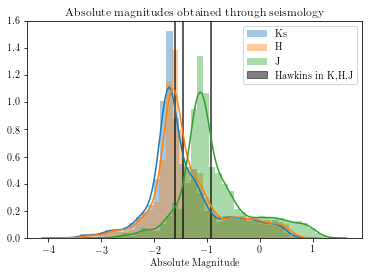

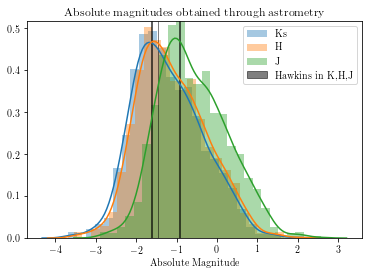

In [45]:
sns.distplot(df.ast_MKs, label='Ks')
sns.distplot(df.ast_MH,label='H')
sns.distplot(df.ast_MJ,label='J')
plt.axvspan(hawkvals['Ks']-hawkerr,hawkvals['Ks']+hawkerr,alpha=.5,color='k',label='Hawkins in K,H,J')
plt.axvspan(hawkvals['H']-hawkerr,hawkvals['H']+hawkerr,alpha=.5,color='k')
plt.axvspan(hawkvals['J']-hawkerr,hawkvals['J']+hawkerr,alpha=.5,color='k')
plt.title('Absolute magnitudes obtained through seismology')
plt.xlabel('Absolute Magnitude')
plt.legend()
plt.show()

sns.distplot(df.phot_MKs, label='Ks')
sns.distplot(df.phot_MH,label='H')
sns.distplot(df.phot_MJ,label='J')
plt.axvspan(hawkvals['Ks']-hawkerr,hawkvals['Ks']+hawkerr,alpha=.5,color='k',label='Hawkins in K,H,J')
plt.axvspan(hawkvals['H']-hawkerr,hawkvals['H']+hawkerr,alpha=.5,color='k')
plt.axvspan(hawkvals['J']-hawkerr,hawkvals['J']+hawkerr,alpha=.5,color='k')
plt.title('Absolute magnitudes obtained through astrometry')
plt.xlabel('Absolute Magnitude')
plt.legend()
plt.show()

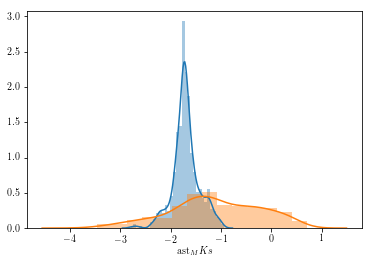

In [46]:
sel = df.stage == 2
sns.distplot(df.ast_MKs[sel], label='Ks')
sns.distplot(df.ast_MKs[~sel])
plt.show()

In [47]:
#Lets calculate the magnitude differences
Kdiff = df.ast_MKs - df.phot_MKs
Kdiff_err = np.sqrt(df.phot_MKs_err**2 + df.ast_M_err**2)

Hdiff = df.ast_MH - df.phot_MH
Hdiff_err = np.sqrt(df.phot_MH_err**2 + df.ast_M_err**2)

Jdiff = df.ast_MJ - df.phot_MJ
Jdiff_err = np.sqrt(df.phot_MJ_err**2 + df.ast_M_err**2)

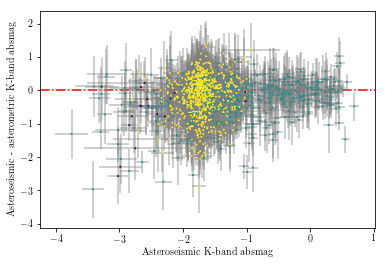

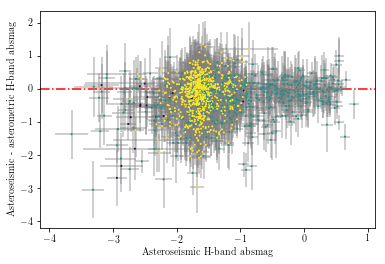

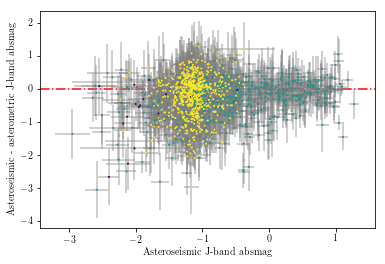

In [48]:
#Plot differences between the two magnitudes
fig, ax = plt.subplots()
diff = df.ast_MKs - df.phot_MKs
err = np.sqrt(df.phot_MKs_err**2 + df.ast_M_err**2)
ax.scatter(df.ast_MKs,diff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.ast_MKs,diff,xerr=df.ast_M_err,yerr=err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Asteroseismic K-band absmag')
ax.set_ylabel('Asteroseismic - asterometric K-band absmag')
plt.show()

fig, ax = plt.subplots()
diff = df.ast_MH - df.phot_MH
err = np.sqrt(df.phot_MH_err**2 + df.ast_M_err**2)
ax.scatter(df.ast_MH,diff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.ast_MH,diff,xerr=df.ast_M_err,yerr=err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Asteroseismic H-band absmag')
ax.set_ylabel('Asteroseismic - asterometric H-band absmag')
plt.show()

fig, ax = plt.subplots()
diff = df.ast_MJ - df.phot_MJ
err = np.sqrt(df.phot_MJ_err**2 + df.ast_M_err**2)
ax.scatter(df.ast_MJ,diff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.ast_MJ,diff,xerr=df.ast_M_err,yerr=err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Asteroseismic J-band absmag')
ax.set_ylabel('Asteroseismic - asterometric J-band absmag')
plt.show()

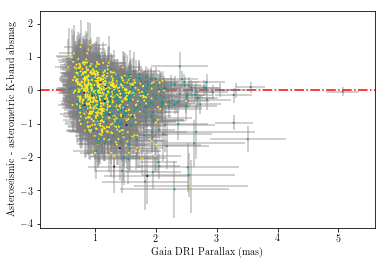

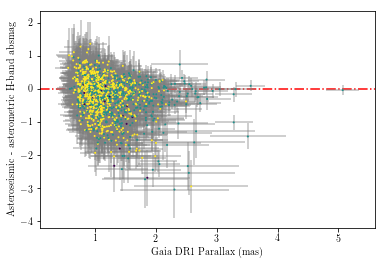

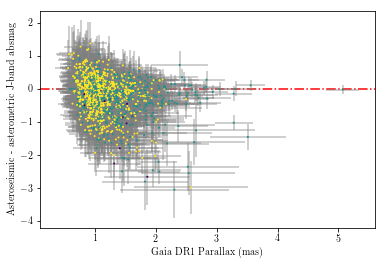

In [49]:
#Now lets plot the difference against distance
fig, ax = plt.subplots()
ax.scatter(df.GAIA_PARALLAX,Kdiff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.GAIA_PARALLAX,Kdiff,xerr=df.GAIA_PARALLAX_ERR,yerr=Kdiff_err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Gaia DR1 Parallax (mas)')
ax.set_ylabel('Asteroseismic - asterometric K-band absmag')
plt.show()

fig, ax = plt.subplots()
ax.scatter(df.GAIA_PARALLAX,Hdiff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.GAIA_PARALLAX,Hdiff,xerr=df.GAIA_PARALLAX_ERR,yerr=Hdiff_err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Gaia DR1 Parallax (mas)')
ax.set_ylabel('Asteroseismic - asterometric H-band absmag')
plt.show()

fig, ax = plt.subplots()
ax.scatter(df.GAIA_PARALLAX,Jdiff,s=1,c=df.stage,zorder=1000)
ax.errorbar(df.GAIA_PARALLAX,Jdiff,xerr=df.GAIA_PARALLAX_ERR,yerr=Jdiff_err,alpha=.5,fmt='none',c='grey',zorder=999)
ax.axhline(0.,linestyle='-.',c='r')
ax.set_xlabel('Gaia DR1 Parallax (mas)')
ax.set_ylabel('Asteroseismic - asterometric J-band absmag')
plt.show()

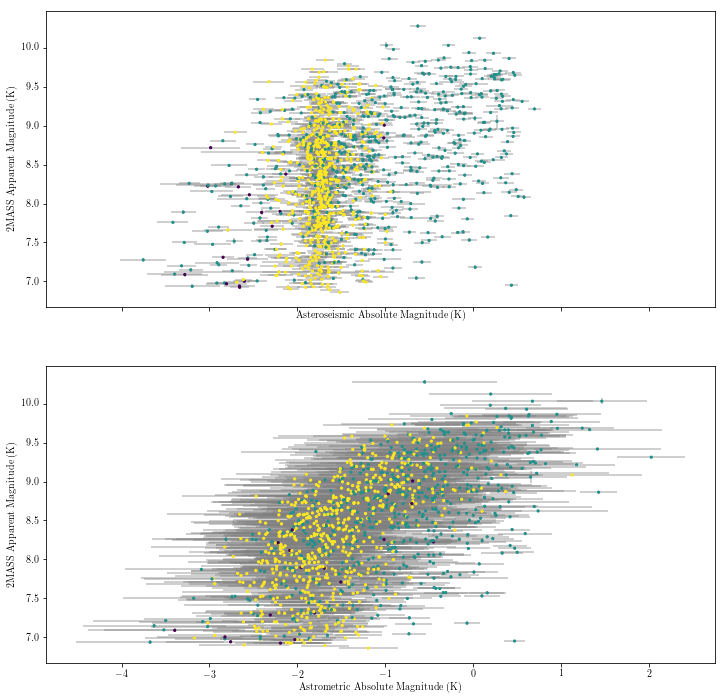

In [50]:
#Lets plot the absolute vs apparent magnitude for both types for the K band
fig, (ax1, ax2) = plt.subplots(2,sharex=True,figsize=(12,12))
ax1.scatter(df.ast_MKs,df.K_MAG_2M,s=5,c=df.stage,zorder=1000)
ax1.errorbar(df.ast_MKs,df.K_MAG_2M,xerr=df.ast_M_err,yerr=df.K_MAG_ERR,alpha=.5,fmt='none',c='grey',zorder=999)
ax1.set_xlabel('Asteroseismic Absolute Magnitude (K)')
ax1.set_ylabel('2MASS Apparent Magnitude (K)')

# fig, ax = plt.subplots()
ax2.scatter(df.phot_MKs,df.K_MAG_2M,s=5,c=df.stage,zorder=1000)
ax2.errorbar(df.phot_MKs,df.K_MAG_2M,xerr=df.phot_MKs_err,yerr=df.K_MAG_ERR,alpha=.5,fmt='none',c='grey',zorder=999)
ax2.set_xlabel('Astrometric Absolute Magnitude (K)')
ax2.set_ylabel('2MASS Apparent Magnitude (K)')
plt.show()

Number of seats in use : 1/5.
Number of seats in use : 2/5.
Number of seats in use : 3/5.
Number of seats in use : 4/5.
Number of seats in use : 5/5.
The barbershop is now full (5 parameter spaces)
Please evict a client if you wish to add another.


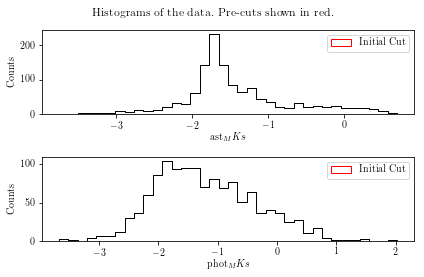

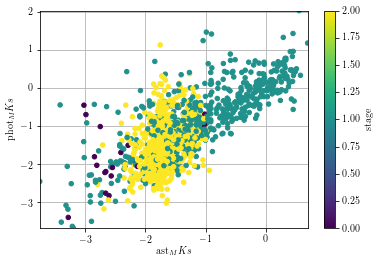

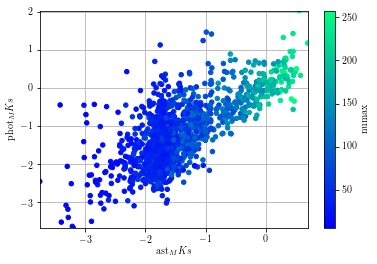

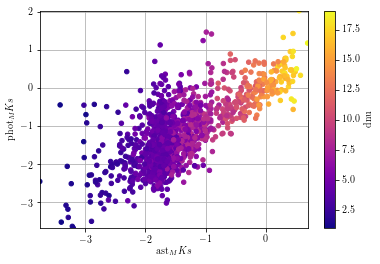

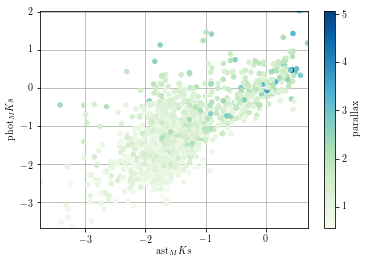

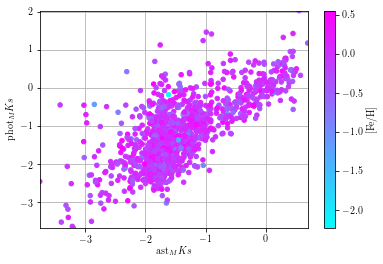

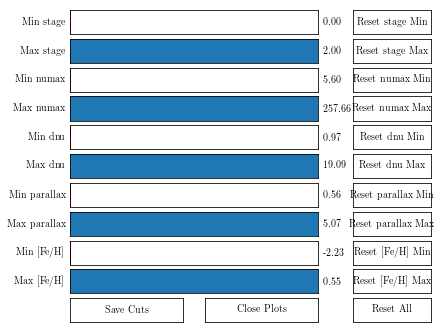

In [51]:
#Finally, lets barbershop a bunch of parameters
import barbershop
df.rename(columns={'GAIA_PARALLAX':'parallax'},inplace=True)
barber = barbershop.open(df,'ast_MKs','phot_MKs')
barber.histograms_on(x=True,y=True)
barber.add_client('stage')
barber.add_client('numax')
barber.add_client('dnu')
barber.add_client('parallax')
barber.add_client('[Fe/H]')
barber.show_mirror()